# Intro

In this notebook, we look at how *JPEG quality factor* affects the compression rates of images.

The "Quality Factor" (QF) is an index for the visual quality of JPEG image. QF ranges from 0-100, with 0 being the worst quality and 100 being the highest quality. However, higher quality images come at the cost of higher disk space. As a result, there is a trade off between image quality and disk space required to store the image. 

To investigate this, we will look at the average number of bytes needed to encode a pixel at different quality 
factors.

## Background

In most widely used color image formats, each pixel is described by three colors channels - red, green, and blue (RGB). For a single pixel, each color component is described by a value between 0 and 255 (an unsigned 8 bit integer), with 0 being darkest and 255 brightest, which requires 1 byte of computer memory to store. As a result each pixel requires 3 bytes of memory: 3 color channels x 1 byte per color channel. 

For example, a standard 10 megapixel image would require 30 megabytes of space to store uncompressed. However, even most images of that size have a size of 1-2 MB, an order magnitude less in size, but still maintain high quality. This is done through JPEG compression, which remove redundant information from the stored version of the image. The [JPEG Wikipedia](https://en.wikipedia.org/wiki/JPEG#Compression_ratio_and_artifacts) article is a pretty good resource for how it works. 


In [1]:
#Imports
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
import os
from tqdm import tqdm

Here are our two main functions:
- `bytes_per_pixel` computes the average number of bytes used to encode a single pixel
- `sweep_qf` will compute the bytes per pixel for a range of JPEG quality factors

In [2]:
def bytes_per_pixel(im_path): 
    img = Image.open(im_path) #read image (lazy open)
    pixels = img.height*img.width #size of image in pixels
    size_in_bytes = os.path.getsize(im_path) #size of image in bytes
    return size_in_bytes/pixels 

def sweep_qf(img, QF=range(1,101)):
    bpp = [] #bytes per pixel list we'll populate for each QF
    for qf in tqdm(QF):
        img.save('tmp.jpg',quality=qf)
        bpp.append(bytes_per_pixel('tmp.jpg'))
    return QF, bpp
    

We'll look at two different images:
1. A **Random** image synthetically created by randomly choosing RGB values. This will provide an upperbound on performance. This is due to the uniform-random distrubition having highest entropy / least predictability
2. A **natural** image, from the "Uncompressed Image Database" (UCID). This image will have slightly higher compression rates for a given quality factor, since it already inherently contains additional predictable structure that will be removed via compression.

Lets take a look at the two images below

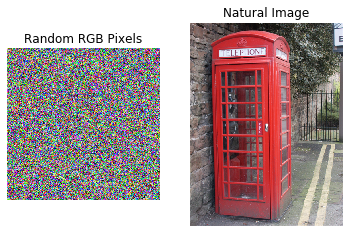

In [3]:
I_random = np.random.randint(0,256,size=(1000,1000,3)).astype(np.uint8) #create random 1 megapixel RGB image
I_natural = plt.imread('ucid00239.tif')

f,ax = plt.subplots(1,2)
ax[0].imshow(I_random)
ax[0].set_title('Random RGB Pixels')
ax[1].imshow(I_natural)
ax[1].set_title('Natural Image')
for a in ax:
    a.axis('off')


Now, we'll calculate the bytes per pixel at QF from 1 to 100. The JPEG compression is performed in the `sweep_qf` function using Pillow.

In [4]:
img_random = Image.fromarray(I_random) #convert to pillow image
img_natural = Image.fromarray(I_natural)

QF=range(1,101)
_,bpp_random = sweep_qf(img_random, QF)
_,bpp_natural = sweep_qf(img_natural, QF)



100%|██████████| 100/100 [00:00<00:00, 175.79it/s]


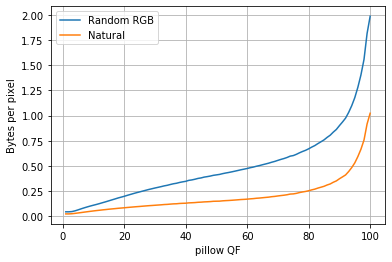

In [5]:
plt.plot(QF,bpp_random,label='Random RGB')
plt.plot(QF,bpp_natural,label='Natural')
plt.grid()
plt.legend()
plt.xlabel('pillow QF')
plt.ylabel('Bytes per pixel')
plt.show()

In the above plot, we see that the bytes per pixel increases with quality factor for both images. At around a QF of 90, the average bytes required to encode a pixel increases much more significantly for each additional QF. 

Typically, JPEG images are saved with QF between 75-90, since this allows still very high quality looking images, without taking up a significant amount of disk space.  

Side note: even though QF=100 does not distort the image, the JPEG algorithm still utilizes some "lossless" compression techniques, which is why we don't see the theoretical maximum of 3 bytes/pixel.

Now, lets take a look at the perceptual quality of different QF.

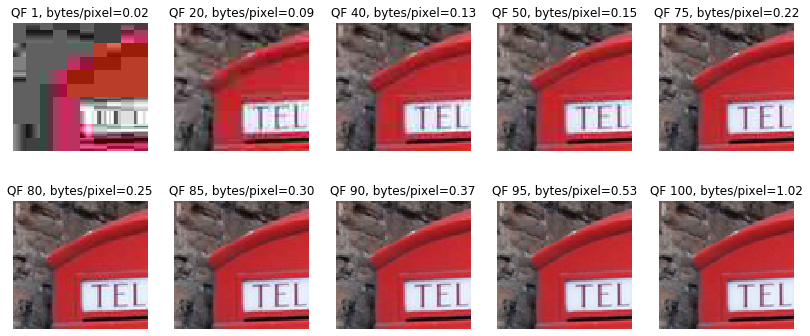

In [6]:
QF = [1, 20, 40, 50, 75, 80, 85, 90, 95, 100] #QFs to look at

ncols = 5
nrows = np.ceil(len(QF)/ncols).astype(int)
f,ax = plt.subplots(nrows,ncols,figsize=(14,6))

x1,x2 = (32,112)
y1,y2 = (20,96)

for ii,qf in enumerate(QF): #iterate over each QF
    img_natural.save('tmp.jpg',quality=qf)
    bpp = bytes_per_pixel('tmp.jpg')
    I = plt.imread('tmp.jpg')
    row = int(np.floor(ii/ncols))
    col = np.remainder(ii,ncols)
    ax[row,col].imshow(I[y1:y2,x1:x2])
    ax[row,col].axis('off')
    ax[row,col].set_title(f"QF {qf}, bytes/pixel={bpp:.2f}")

Some things to observe:
- Quality at QF=1 is undecipherable
- Quality is poor until QF = ~40-50. Notice the heavy blocking artifacts near the boundary of the telephone booth.
- At low QF, small increases in disk space (bytes/pixel) signficantly increase the quailty. 
- Perceptual quality is very good at QF=90, and artifacts are minimal and almost un-noticeable without having higher quality comparisons.
- Going from QF=95 to QF=100 requires nearly doubling the disk space requirement for the image. This is almost always not worth it.
